<a href="https://colab.research.google.com/github/cagBRT/computer-vision/blob/master/CV7a_ImageSegmenation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone the entire repo.
import cv2
from google.colab.patches import cv2_imshow
!git clone -l -s https://github.com/cagBRT/computer-vision.git cloned-repo
%cd cloned-repo

Cloning into 'cloned-repo'...
remote: Enumerating objects: 3887, done.
remote: Counting objects: 100% (198/198), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 3887 (delta 108), reused 106 (delta 59), pack-reused 3689
Receiving objects: 100% (3887/3887), 424.76 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (1443/1443), done.
Updating files: 100% (2300/2300), done.
/content/cloned-repo


# **Image Segmentation**<br>
We can divide or partition the image into various parts called segments. It’s not a great idea to process the entire image at the same time as there will be regions in the image which do not contain any information. By dividing the image into segments, we can make use of the important segments for processing the image. That, in a nutshell, is how image segmentation works.

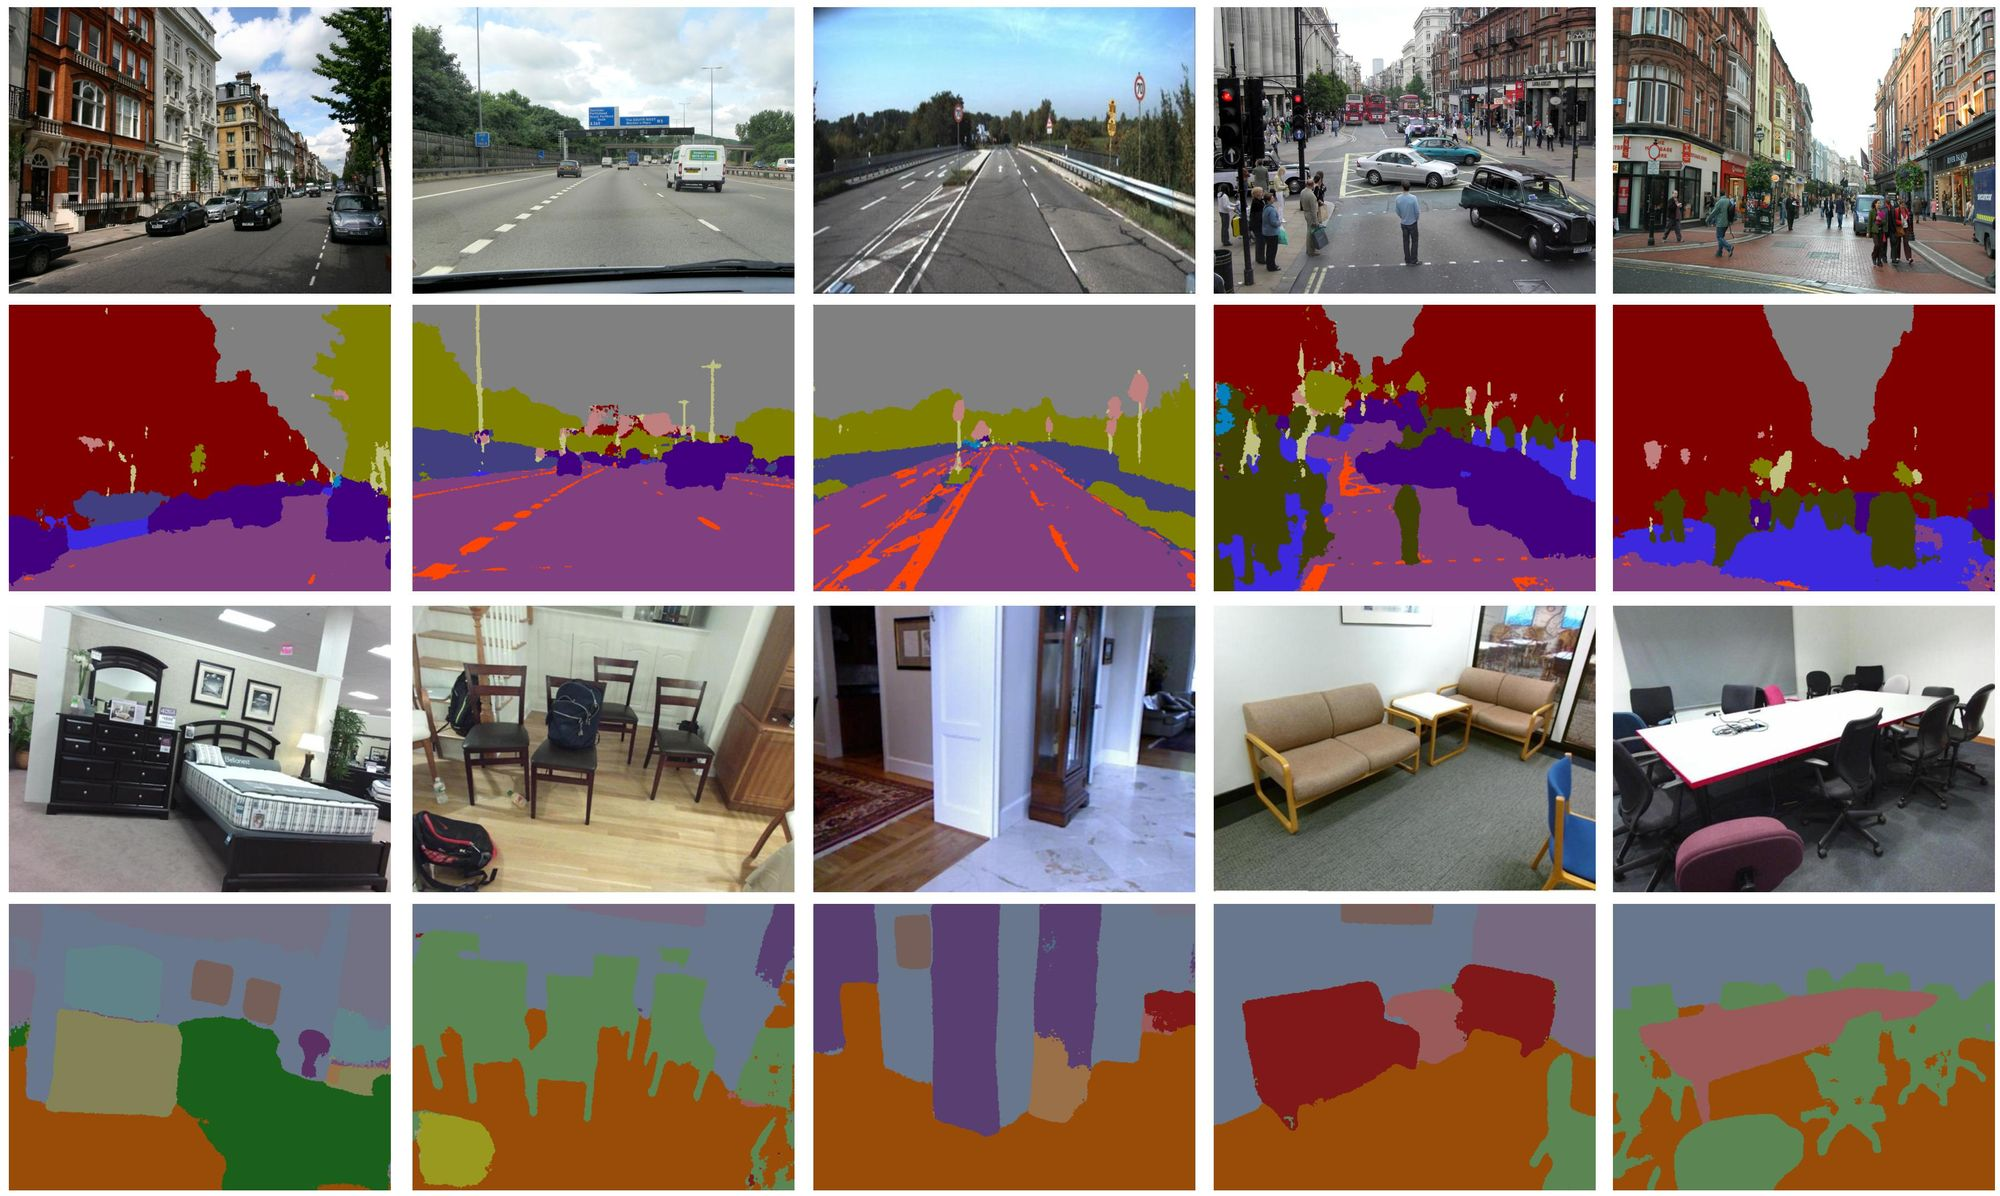

In [2]:
image = cv2.imread("images/CamVidTeaserwithIndoorScenes.jpg")
cv2_imshow(image)

Image segmentation creates a pixel-wise mask for each object in the image. This technique gives us a far more granular understanding of the object(s) in the image.

Why do we need Image Segmentation?
Cancer has long been a deadly illness. Even in today’s age of technological advancements, cancer can be fatal if we don’t identify it at an early stage. Detecting cancerous cell(s) as quickly as possible can potentially save millions of lives.

The shape of the cancerous cells plays a vital role in determining the severity of the cancer. You might have put the pieces together – object detection will not be very useful here. We will only generate bounding boxes which will not help us in identifying the shape of the cells.

Image Segmentation techniques make a MASSIVE impact here. They help us approach this problem in a more granular manner and get more meaningful results. A win-win for everyone in the healthcare industry.

**Install the required libraries**

In [3]:
!pip3 install -q git+https://github.com/tensorflow/examples.git
!pip3 install -q -U tfds-nightly

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 22.0 MB/s eta 0:00:00


**Import the dependencies**

In [4]:
import tensorflow as tf

In [5]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

**Load the dataset**<br>
The [Oxford-IIIT pet dataset](https://www.tensorflow.org/datasets/catalog/oxford_iiit_pet) is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed.

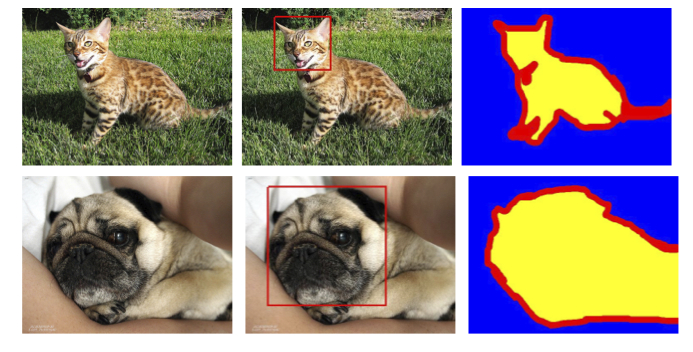

In [6]:
image = cv2.imread("images/pet_annotations.jpg")
cv2_imshow(image)

In [7]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXBKFGI/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteXBKFGI/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


**Helper functions** for normailizing the data and loading images

In [8]:
#@title Helper Functions
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [9]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [10]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [11]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

**Set the constants**

In [12]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

**Prepare the training and test sets**

In [13]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [14]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

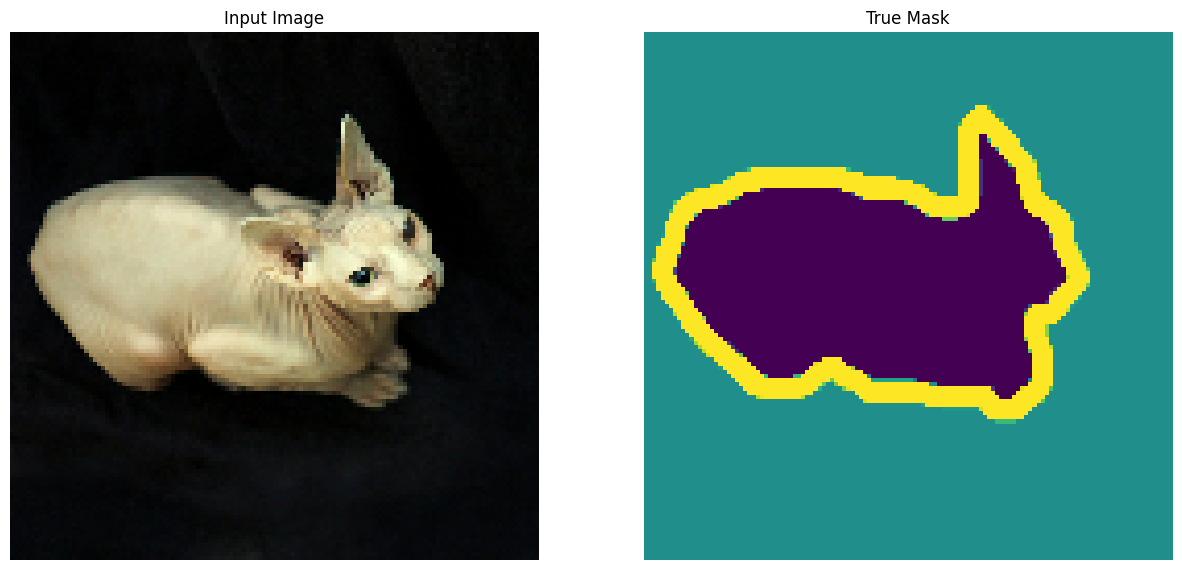

In [15]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [16]:
OUTPUT_CHANNELS = 3

**Create the model**<br>
The base for this model is the MobileNetV2.<br>

MobileNetV2 is a significant improvement over MobileNetV1 and pushes the state of the art for mobile visual recognition including classification, object detection and semantic segmentation

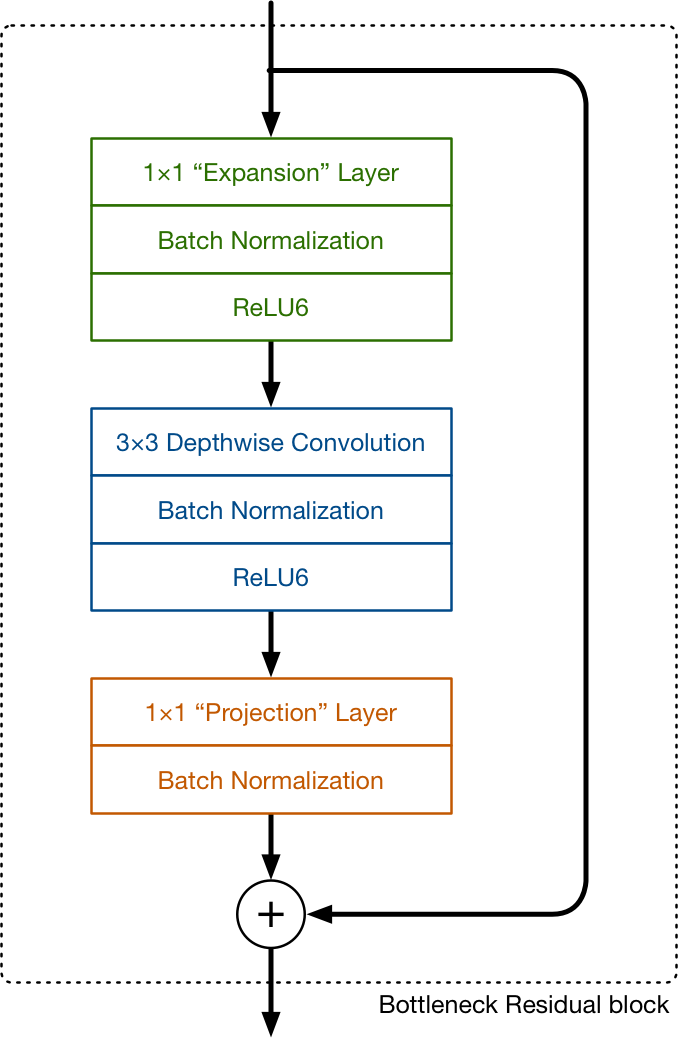

In [17]:
image = cv2.imread("images/ResidualBlock@2x.png")
cv2_imshow(image)

In depth-wise convolution, we use each filter channel only at one input channel. In the image below, we have 3 channel filter and 3 channel image. We break the filter and image into three different channels and then convolve the corresponding image with corresponding channel and then stack them back

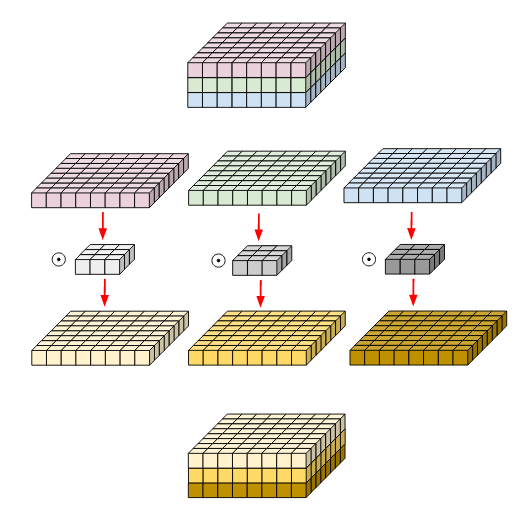

In [18]:
image = cv2.imread("images/convolutiondepthWise.png")
cv2_imshow(image)

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [20]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [21]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [22]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 64, 64, 96),         1841984   ['input_2[0][0]']             
                              (None, 32, 32, 144),                                                
                              (None, 16, 16, 192),                                                
                              (None, 8, 8, 576),                                                  
                              (None, 4, 4, 320)]                                                  
                                                                                            

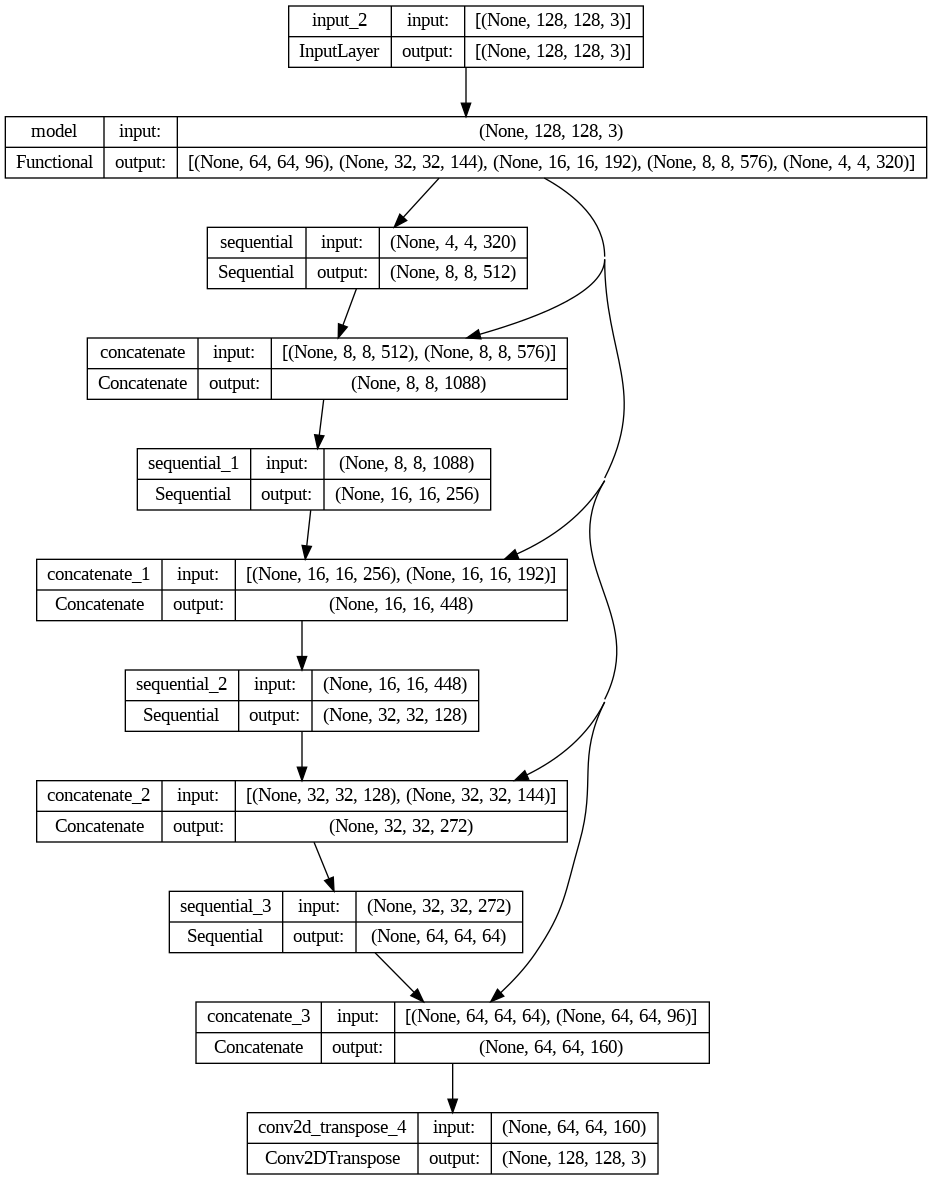

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True)

**Display the image, it's true mask, and the prediction mask**

In [25]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [26]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 12s 12s/step


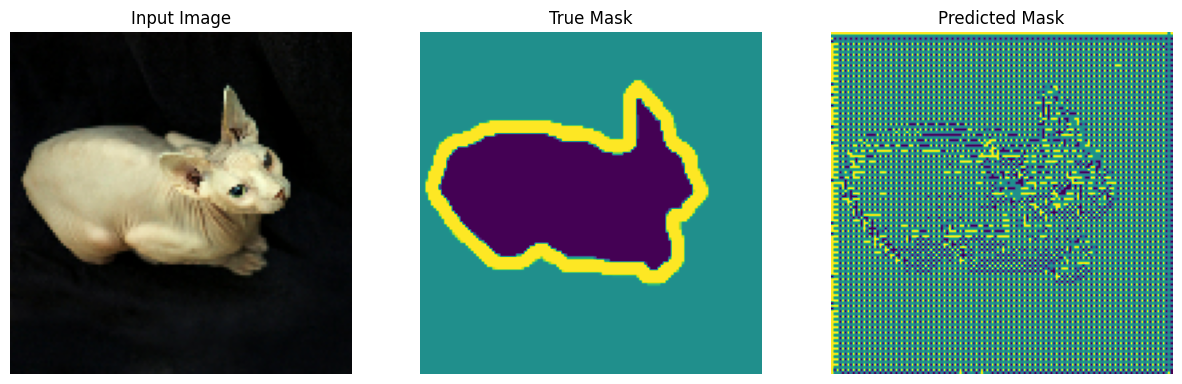

In [27]:
show_predictions()

**Train the model** <br>
Watch the predicted mask, it will change for each epoch.

In [28]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 25ms/step


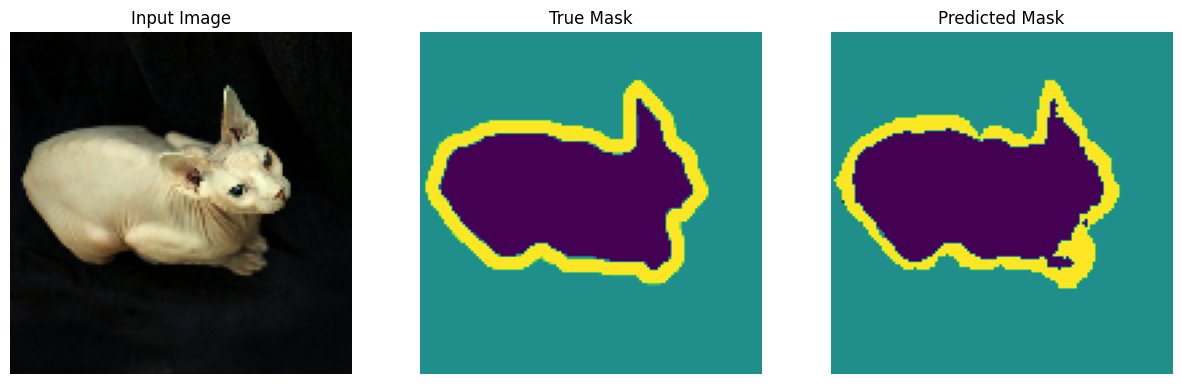


Sample Prediction after epoch 20

57/57 [==============================] - 9s 166ms/step - loss: 0.1354 - accuracy: 0.9382 - val_loss: 0.3197 - val_accuracy: 0.8905


In [29]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

**Plot the loss per epoch for the model**

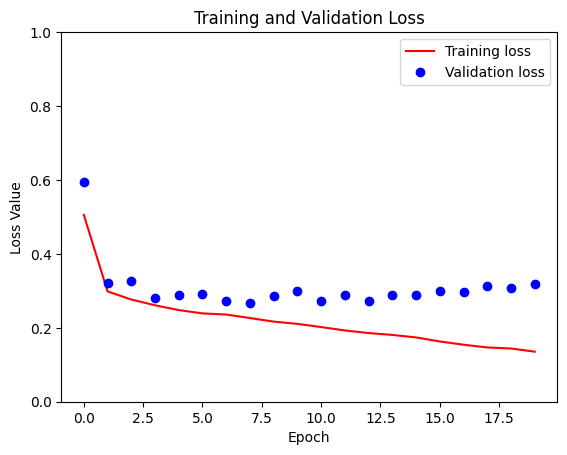

In [30]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

2/2 [==============================] - 0s 60ms/step


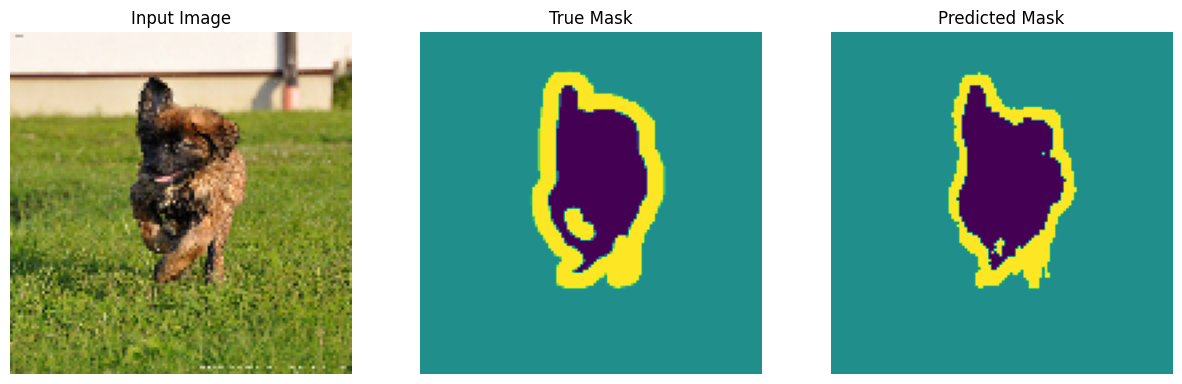

2/2 [==============================] - 0s 59ms/step


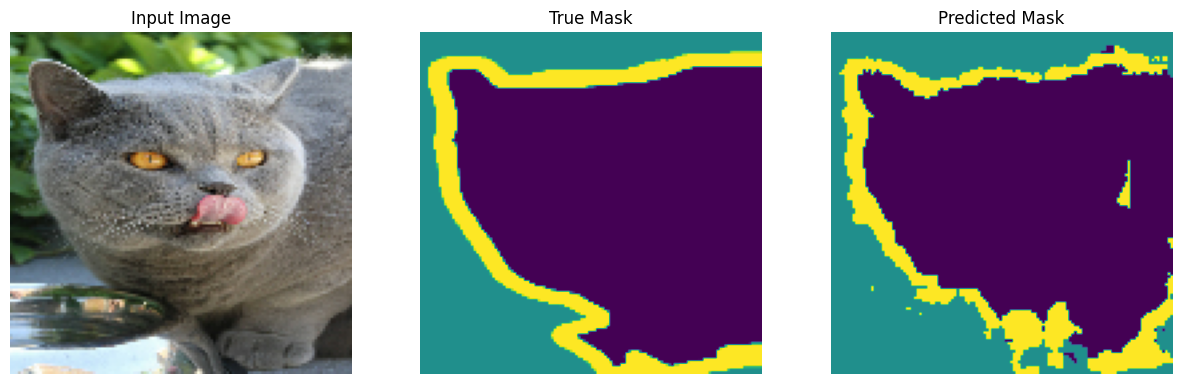

2/2 [==============================] - 0s 73ms/step


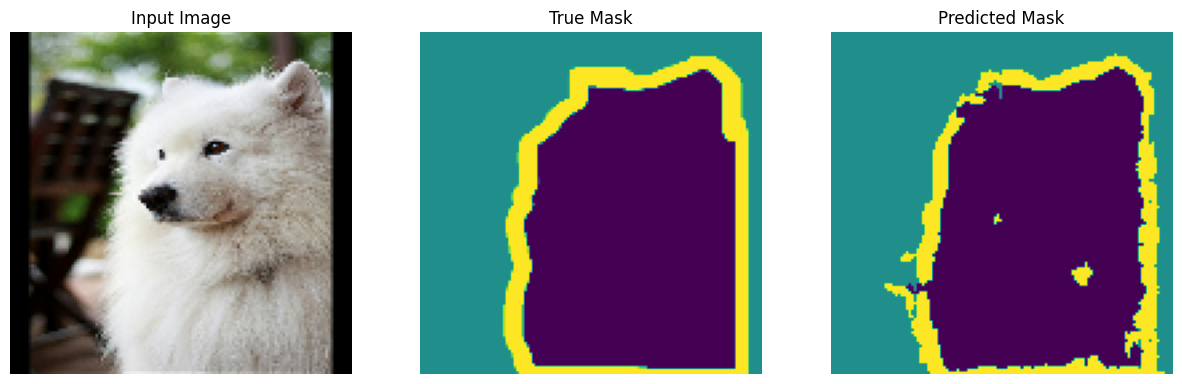

2/2 [==============================] - 0s 48ms/step


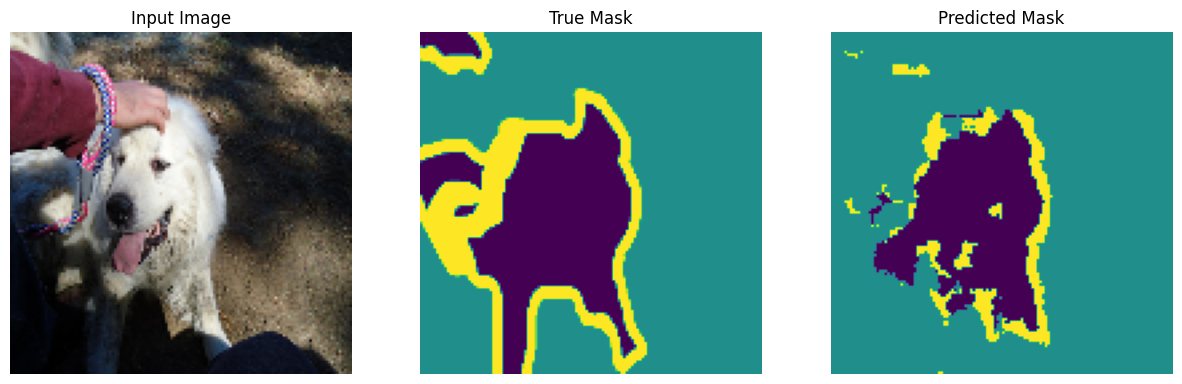

In [31]:
show_predictions(test_dataset, 4) #The number determines how many pets to show

# **Assignment**
The trained model has an issue, fix the problem and re-run the model on the images.